In [ ]:
%load_ext autoreload
%autoreload

import pandas as pd; pd.set_option('display.max_columns', 30)
import numpy as np
from cmlreaders import CMLReader, get_data_index
import ptsa
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sb
from pylab import *
from copy import copy
from scipy import stats
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
sys.path.append('/home1/john/SWRrefactored/code/SWR_modules/')
from SWRmodule import *
from general import * #superVstack,findInd,findAinB
from power_functions import z_score, process_power, load_z_scored_power

# base = '/home1/john/SWRrefactored'
# sys.path.append(f'{base}/code/')

# from load_data_numpy import load_data_np
# from SWRmodule import triangleSmooth
# # from comodulogram import remove_session_string, get_filtered_signal
# # from fooof import FOOOF

# import statsmodels.formula.api as smf
# from scipy.signal import decimate, resample, hilbert, welch, spectrogram
# from mne.time_frequency import tfr_array_morlet

# # Import the time & event model objects and Bands object to manage oscillation band definitions
# from specparam import SpectralTimeModel, SpectralTimeEventModel, Bands
# # Import helper utilities for simulating and plotting spectrograms
# from specparam.sim import sim_spectrogram
# from specparam.plts.spectra import plot_spectrogram

In [33]:
# for now the plotting code only works with one region at a time
region_name = ['HPC'] 
subregion = ['ca1']
task = 'catFR1' # 'catFR1'
savePath = f'{base}/figures/'

# 1 for encoding, 0 for recall
encoding_mode_arr = [1] #[0,1] 
freq_range_str_arr = ['high', 'low']

# define frequency ranges
low_fq_range = [[2,4],[7,9]]
high_fq_range = [[30,75], [80,170]]

plot_error_bars = True

In [ ]:
for encoding_mode in encoding_mode_arr:

    dd_trials = load_data_np(encoding_mode,task,
        region_name=region_name, train_only=False, subregion=subregion)
    
    region_str = region_name[0]
    subregion_str = subregion[0]
    
    clust = dd_trials['clust_int']
    notclust_idxs = np.argwhere(clust<0).squeeze()
    clust_idxs = np.argwhere(clust>0).squeeze()
    
    if encoding_mode:
        saveName = 'encoding_'
        recall_str = ''
        time = np.linspace(-0.7, 2.3, 150)
        correct = dd_trials['correct']
        incorrect_idxs = np.argwhere(correct==0).squeeze()
        
    else:
        saveName = 'recall_'
        recall_str = '_recall'
        time = np.linspace(-2, 2, 200)
    
    for power_z, ylabel in load_z_scored_power(dd_trials, freq_range_str_arr, encoding_mode):

        if len(subregion[0]) > 0:
            subregion_str = f'_{subregion[0]}'
        else:
            subregion_str = ''
            
        if 'Gamma' in ylabel:
            fq_range = high_fq_range
        elif 'Theta' in ylabel:
            fq_range = low_fq_range
    
        # loop through sub-bands of gamma or theta
        for power_z_i, f in zip(power_z, fq_range): 

            plt.figure(figsize=(10,6))

            # Calculate mean and SEM
            mean_clust = np.mean(power_z_i[clust_idxs].squeeze(), axis=0)
            mean_not_clust = np.mean(power_z_i[notclust_idxs].squeeze(), axis=0)
            sem_clust = np.std(power_z_i[clust_idxs].squeeze(), axis=0) / np.sqrt(len(clust_idxs))
            sem_not_clust = np.std(power_z_i[notclust_idxs].squeeze(), axis=0) / np.sqrt(len(notclust_idxs))
            
            # Apply smoothing
            mean_clust_smooth = triangleSmooth(mean_clust, smoothing_triangle=5)
            mean_not_clust_smooth = triangleSmooth(mean_not_clust, smoothing_triangle=5)
            sem_clust_smooth = triangleSmooth(sem_clust, smoothing_triangle=5)
            sem_not_clust_smooth = triangleSmooth(sem_not_clust, smoothing_triangle=5)

            # Plotting
            plt.plot(time, mean_clust_smooth, color='tab:blue', alpha=0.8, label="Clust")
            plt.plot(time, mean_not_clust_smooth, color='tab:orange', alpha=0.8, label="Not Clust")
            
            if plot_error_bars:
                plt.fill_between(time, mean_clust_smooth - sem_clust_smooth, mean_clust_smooth + sem_clust_smooth, 
                                 color='tab:blue', alpha=0.3)
                plt.fill_between(time, mean_not_clust_smooth - sem_not_clust_smooth, mean_not_clust_smooth + sem_not_clust_smooth,
                                 color='tab:orange', alpha=0.3)
                
            # plot not recalled data for encoding 
            if encoding_mode:
                mean_not_recalled = np.mean(power_z_i[incorrect_idxs].squeeze(), axis=0)
                mean_not_recalled_smooth = triangleSmooth(mean_not_recalled, smoothing_triangle=5)
                
                sem_not_recalled = np.std(power_z_i[incorrect_idxs].squeeze(), axis=0) / np.sqrt(len(incorrect_idxs))
                sem_not_recalled_smooth = triangleSmooth(sem_not_recalled, smoothing_triangle=5)
                                                    
                plt.plot(time, mean_not_recalled_smooth, color='tab:pink', alpha=0.8, label="Not Recalled")
                
                if plot_error_bars:
                    plt.fill_between(time, mean_not_recalled - sem_not_recalled_smooth, 
                                     mean_not_recalled + sem_not_recalled_smooth, color='tab:pink', alpha=0.3)
                

            plt.axvline(0, color='black')
            plt.ylabel(f"{ylabel} ({f[0]}-{f[1]} Hz)", fontsize=18)
            plt.xlabel("Time", fontsize=18)
            sb.despine()
            plt.legend(fontsize=16)
            plt.savefig(f"{savePath}/{ylabel}_{f[0]}-{f[1]}_zscore_elec_{region_str}{subregion_str}{recall_str}", dpi=300, 
                        bbox_inches='tight')
            plt.savefig(f"{savePath}/{ylabel}_{f[0]}-{f[1]}_zscore_elec_{region_str}{subregion_str}{recall_str}.pdf",
                        bbox_inches='tight')
            plt.show()

Loading data
LOADING DATA FROM: HPC FOR EXPERIMENT FR1
elec_by_elec_correlation
> /home1/john/SWRrefactored/code/SWR_modules/load_data.py(360)select_region()
    359                 import ipdb; ipdb.set_trace()
--> 360                 data_dict_selected_elecs[key].append(val[sess][:, selected_ind])
    361 



ipdb>  c


> /home1/john/SWRrefactored/code/SWR_modules/load_data.py(359)select_region()
    358 #                 print(f'{sess},{selected_ind}')
--> 359                 import ipdb; ipdb.set_trace()
    360                 data_dict_selected_elecs[key].append(val[sess][:, selected_ind])



ipdb>  key


'clust'


ipdb>  val


[array([], shape=(180, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(180, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(288, 0), dtype=float64), array([], shape=(204, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(180, 0), dtype=float64), array([], shape=(192, 0), dtype=float64), array([], shape=(252, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(300, 0), dtype=float64), array([], shape=(300, 0), dtype=f

ipdb>  len(val)


30


ipdb>  sess


0


ipdb>  selected_ind


[2, 3]


ipdb>  one_d_keys


['trial_by_trial_correlation', 'elec_by_elec_correlation', 'elec_names', 'elec_labels', 'elec_ripple_rate_array']


ipdb>  val[sess][:, selected_ind]


*** IndexError: index 2 is out of bounds for axis 1 with size 0


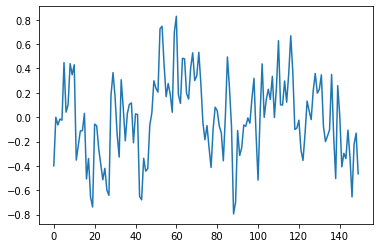

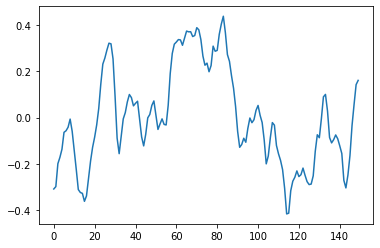

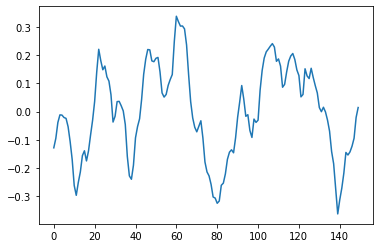

In [ ]:
plt.plot(np.mean(filtered_sig_power[2, selected_elec_idxs].squeeze(),axis=0))
plt.show()
plt.plot(np.mean(filtered_sig_power[1, selected_elec_idxs].squeeze(),axis=0))
plt.show()
plt.plot(np.mean(filtered_sig_power[0, selected_elec_idxs].squeeze(),axis=0))
plt.show()


In [ ]:
from neurodsp.timefrequency.wavelets import compute_wavelet_transform
from mne.time_frequency import tfr_array_morlet
from neurodsp.plts import plot_time_series, plot_timefrequency

In [ ]:
frequencies_low = [1,2,3,4,5,6,7,8,9,10]
frequencies_high = np.arange(10,156,5)
frequencies = np.hstack((frequencies_low, frequencies_high))
n_freqs = frequencies.shape[0]
n_cycles = np.floor(np.linspace(2,15,n_freqs))

In [ ]:
# Define general settings for across the example
for selected_elec in np.unique(subj_elec_sess_labels):
    print(selected_elec)
    #selected_elec = best_power_elec
    selected_elec_idxs = np.argwhere(subj_elec_sess_labels==selected_elec)
    raw_data_elec = raw_data[selected_elec_idxs].squeeze()
    fs = 500

    buffer = 500

    power_elec = tfr_array_morlet(np.expand_dims(raw_data_elec, axis=1), sfreq=500, 
                                  freqs=frequencies, output='power', n_cycles=n_cycles)
    mwt = np.mean(power_elec.squeeze()[:, :, buffer:-buffer],axis=0) 

    # Define the baseline period as -500 ms to -100 ms 
    baseline_pow = np.mean(mwt[:, 100:300],axis=1)

    mwt = mwt/np.expand_dims(baseline_pow,axis=1)

    mwt_decibal = 10 * np.log10(mwt[:, 350:1100])

    # plot data from 0 - 1500 ms 
    times = np.linspace(0,1.5,750)
    plt.pcolormesh(times, frequencies, mwt_decibal, shading='gouraud')
    plt.colorbar(label='Baseline Normalized Power (dB)')
    plt.xlabel("Time after word onset (sec)", fontsize=14)
    plt.ylabel("Frequency (Hz)", fontsize=14)
    plt.title(selected_elec, fontsize=16)
    plt.savefig(f'baselinenorm_spectrograms/{selected_elec}_6_16', dpi=300)
    plt.close()

R1065J-0_LE2-LE3
R1065J-0_LS1-LS2
R1065J-0_LS11-LS12
R1065J-0_LS12-LS13
R1065J-0_LS3-LS4
R1065J-0_LS4-LS5
R1065J-0_LS5-LS6
R1065J-0_LS6-LS7
R1065J-0_LS7-LS8
R1065J-1_LE2-LE3
R1065J-1_LS1-LS2
R1065J-1_LS11-LS12
R1065J-1_LS12-LS13
R1065J-1_LS3-LS4
R1065J-1_LS4-LS5
R1065J-1_LS5-LS6
R1065J-1_LS6-LS7
R1065J-1_LS7-LS8
R1065J-2_LE2-LE3
R1065J-2_LS1-LS2
R1065J-2_LS11-LS12
R1065J-2_LS12-LS13
R1065J-2_LS3-LS4
R1065J-2_LS4-LS5
R1065J-2_LS5-LS6
R1065J-2_LS6-LS7
R1065J-2_LS7-LS8
R1065J-3_LE2-LE3
R1065J-3_LS1-LS2
R1065J-3_LS11-LS12
R1065J-3_LS12-LS13
R1065J-3_LS3-LS4
R1065J-3_LS4-LS5
R1065J-3_LS5-LS6
R1065J-3_LS6-LS7
R1065J-3_LS7-LS8
R1105E-0_RORBFD1-RORBFD2
R1108J-0_RU1-RU2
R1108J-0_RU3-RU4
R1108J-0_RU4-RU5
R1108J-0_RU5-RU6
R1108J-0_RU6-RU7
R1108J-0_RU8-RU9
R1108J-1_RU1-RU2
R1108J-1_RU3-RU4
R1108J-1_RU4-RU5
R1108J-1_RU5-RU6
R1108J-1_RU6-RU7
R1108J-1_RU8-RU9
R1108J-2_RU1-RU2
R1108J-2_RU3-RU4
R1108J-2_RU4-RU5
R1108J-2_RU5-RU6
R1108J-2_RU6-RU7
R1108J-2_RU8-RU9
R1108J-3_RU1-RU2
R1108J-3_RU3-RU4
R1108J-

In [ ]:
power_elec = tfr_array_morlet(np.expand_dims(raw_data, axis=1), sfreq=500, 
                              freqs=frequencies, output='power', n_cycles=n_cycles)
mwt = np.mean(power_elec.squeeze()[:, :, buffer:-buffer],axis=0) 

# Define the baseline period as -500 ms to -100 ms 
baseline_pow = np.mean(mwt[:, 100:300],axis=1)

mwt = mwt/np.expand_dims(baseline_pow,axis=1)

mwt_decibal = 10 * np.log10(mwt[:, 350:1100])

# plot data from 0 - 1500 ms 
times = np.linspace(0,1.5,750)
plt.pcolormesh(times, frequencies, mwt_decibal, shading='gouraud')
plt.colorbar(label='Baseline Normalized Power (dB)')
plt.xlabel("Time after word onset (sec)", fontsize=14)
plt.ylabel("Frequency (Hz)", fontsize=14)
plt.title(selected_elec, fontsize=16)
plt.savefig(f'baselinenorm_spectrograms/{selected_elec}_6_16', dpi=300)
plt.close()

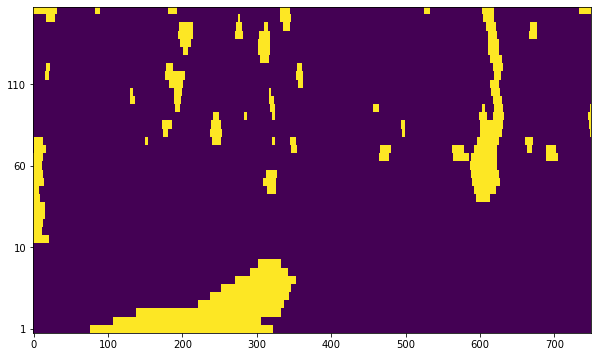

In [141]:
# Create a mask where True indicates values above the threshold
significant_mask = mwt_decibal > 0.5

# Plot the significant mask
plt.figure(figsize=(10, 6))
plt.yticks(np.arange(0, len(frequencies), 10), frequencies[::10]) 
plt.imshow(significant_mask, aspect='auto', origin='lower')
plt.show()


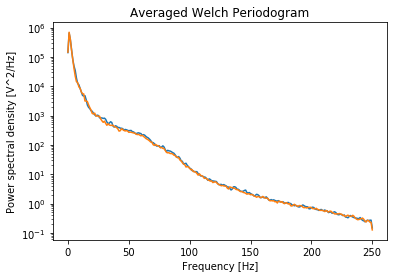

In [270]:
# Store the results
Pxx_base_list = []
Pxx_list = []

fs = 500
nperseg = 256
n_trials = raw_data_elec.shape[0]

start_roi = 200
end_roi = 1200
baseline_start = -700
baseline_end = 300

sr_factor = 1000 / fs
# convert to indices based on start time and sampling rate factor
start_idx = int((start_roi - start_time)/sr_factor)
end_idx = int((end_roi-start_time)/sr_factor)

# convert to indices based on start time and sampling rate factor
baseline_start_idx = int((baseline_start - start_time)/sr_factor)
baseline_end_idx = int((baseline_end - start_time)/sr_factor)

nperseg = int(end_idx - start_idx)
nperseg_base = int(baseline_end_idx - baseline_start_idx)

for trial in range(n_trials):
    f, Pxx = welch(raw_data_elec[trial, start_idx:end_idx], 
                   fs=fs, nperseg=nperseg)
    f_base, Pxx_base = welch(raw_data_elec[trial, baseline_start_idx:baseline_end_idx], 
                   fs=fs, nperseg=nperseg_base)

    Pxx_list.append(Pxx)
    Pxx_base_list.append(Pxx_base)
    

Pxx_array = np.array(Pxx_list)
Pxx_base_array = np.array(Pxx_base_list)

Pxx_mean = np.mean(Pxx_array, axis=0)
Pxx_base_mean = np.mean(Pxx_base_array, axis=0)


# Plot the averaged periodogram
plt.figure()
plt.semilogy(f, Pxx_mean)
plt.semilogy(f_base, Pxx_base_mean)
plt.xlabel('Frequency [Hz]')
plt.ylabel('Power spectral density [V^2/Hz]')
plt.title('Averaged Welch Periodogram')
plt.show()


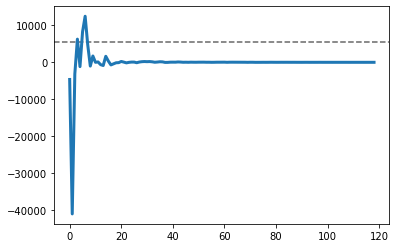

In [271]:
plot_end_idx = 119 # 170 Hz
Pxx_diff = Pxx_mean-Pxx_base_mean
Pxx_diff_mean = np.mean(Pxx_diff)
Pxx_diff_std = np.std(Pxx_diff)
plt.axhline(Pxx_diff_mean+Pxx_diff_std*2, color='black', alpha=0.6, linestyle='--')
plt.plot(f[:plot_end_idx], Pxx_diff[:plot_end_idx], linewidth=3)
plt.show()

In [238]:
np.argwhere(f==max_freq_to_plot)

array([], shape=(0, 1), dtype=int64)

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                       The model was run on the frequency range 0 - 150 Hz                        
                                 Frequency Resolution is 0.71 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                      4.1529, 8.9977, 2.5010                                      
                                                                                                  
                                       9 peaks were found:                                        
          

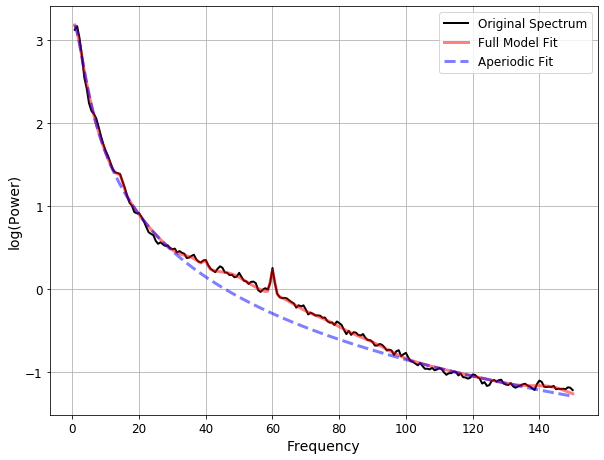

In [205]:
# Initialize a model object
fm = FOOOF(peak_width_limits=[1.2,12], aperiodic_mode='knee')

# Set the frequency range to fit the model
freq_range = [0.1,150]

# Report: fit the model, print the resulting parameters, and plot the reconstruction
fm.report(f, Pxx_mean, freq_range)

In [ ]:
fs = 1  # Sampling frequency, adjust as per your data
nperseg = 1500  # Length of each segment

# Store the results
f_list = []
Pxx_list = []

for trial in range(n_trials):
    f, Pxx = welch(data[trial, :], fs=fs, nperseg=nperseg)
    f_list.append(f)
    Pxx_list.append(Pxx)

# Convert lists to numpy arrays for easier handling
f_array = np.array(f_list)
Pxx_array = np.array(Pxx_list)

In [206]:
gamma_include_indices = np.argwhere((max_indices >= 45) & (max_indices <= 115))

In [202]:
theta_include_indices = np.argwhere((max_indices >= 45) & (max_indices <= 115))

In [207]:
np.intersect1d(theta_include_indices, gamma_include_indices).shape[0]

102

In [163]:
# relative to word onset, in ms 
start_roi = 200
end_roi = 900
baseline_start_roi = -700
baseline_end_roi = 0
correct = dd_trials['correct']
correct_idxs = np.argwhere(correct==1)

# convert to indices based on start time and sampling rate factor
start_idx = int((start_roi - start_time)/sr_factor)
end_idx = int((end_roi-start_time)/sr_factor)
baseline_start_idx = int((baseline_start_roi - start_time)/sr_factor)
baseline_end_idx = int((baseline_end_roi - start_time)/sr_factor)

electrode_trial_count = []
electrode_p_value_ttest = []
electrode_p_value_wilcox = []
electrode_label = []
electrode_max_time = []

for seu in subj_elec_unique:
    
    electrode_label.append(seu)
    
    se_idxs = np.argwhere(subj_elec_sess_labels==seu).squeeze()
    
    se_correct_idxs = np.intersect1d(se_idxs, correct_idxs).squeeze()
    
    filtered_elec = filtered_sig_power[se_idxs].squeeze()
    
    pow_roi = np.mean(filtered_elec[:, start_idx:end_idx], axis=1)
    pow_base = np.mean(filtered_elec[:, baseline_start_idx:baseline_end_idx], axis=1)
    
    ttest_res = ttest_rel(pow_roi, pow_base, alternative='greater')
    
    d = np.around(pow_roi-pow_base, decimals=5)
    wilcox_res = wilcoxon(d, alternative='greater')
    
    electrode_p_value_ttest.append(ttest_res.pvalue)
    electrode_p_value_wilcox.append(wilcox_res.pvalue)
    
    electrode_trial_count.append(se_idxs.shape[0])

    

In [99]:
print("Number of electrodes: ", len(electrode_label))

Number of electrodes:  201


In [100]:
print("Number of nonsig elecs by ttest: ", np.argwhere(np.array(electrode_p_value_ttest) > 0.05).shape[0])
print("Number of nonsig elecs by wilcox: ", np.argwhere(np.array(electrode_p_value_wilcox) > 0.05).shape[0])

Number of nonsig elecs by ttest:  129
Number of nonsig elecs by wilcox:  123


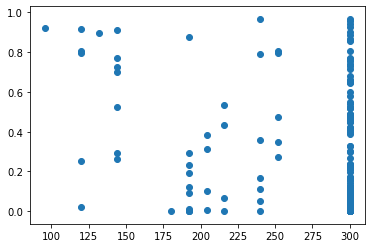

In [94]:
plt.scatter(electrode_trial_count, electrode_p_value_ttest)

In [32]:
elec_stats = pd.DataFrame({'electrode_label': electrode_label, 'pval_t_test': electrode_p_value_ttest, 'pval_wilcox': electrode_p_value_wilcox, 
                  'electrode_trial_count': electrode_trial_count})
elec_stats.to_csv(f"{savePath}/{freq_band}_elec_stats.csv")

NameError: name 'savePath' is not defined